$$\text{
Importing the Necessary Libraries
}
$$

In [1]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix


$$\text{
Setting Global Varables
}
$$

In [2]:
###----------------
# Global Variables
###----------------


RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)



TEST_SIZE =  0.2
ALPHA = 0.001
EPOCHS = 20
BATCH_SIZE = 32
PATIENCE = 6
LR_FACTOR = 0.1
LR_PATIENCE = 10

# set location of input files and output files
inpDir = '../input'
outDir = '../output'
modelDir = '../models' 
subDir = 'fashion_mnist'


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')




In [3]:
def accuracy_socre_confusion_matrix(data_ds, prediction_model, labels):
    y_true, y_pred = [], []
    for count, data in enumerate(data_ds):
        feat, label = data
        pred = prediction_model(feat).numpy().argmax(axis=1)
        y_true.extend(label)
        y_pred.extend(pred)
        
    print(len(y_true), len(y_pred))

    print(accuracy_score(y_true=y_true, y_pred=y_pred)*100)

    fn_plot_confusion_matrix(y_true, y_pred, labels=labels)

In [4]:
def fn_plot_labels(train_df:pd.DataFrame, test_df:pd.DataFrame): 
    """Plotting the distribution of labels in the training and testing data

    Args:
        train (pd.DataFrame): Data For Training
        test (pd.DataFrame): Data For Testing
    Returns:
        None
    """
    plt.subplot(1, 2, 1)
    ax = train_df['label'].value_counts().plot(
        kind='bar', 
        title='Training Dsitrinbution',
        color='DarkBlue',
        alpha=0.8
    )
    plt.subplot(1, 2, 2)
    ax = test_df['label'].value_counts().plot(
        kind='bar', 
        title='Valid Distribution',
        color='Red',
        alpha=0.8
    )
    plt.show()

$$\text{
    Loading the data
}
$$

In [5]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
valid_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
valid_df = pd.read_csv(valid_filename, header = 0)


train_df.shape, valid_df.shape

((60000, 785), (10000, 785))

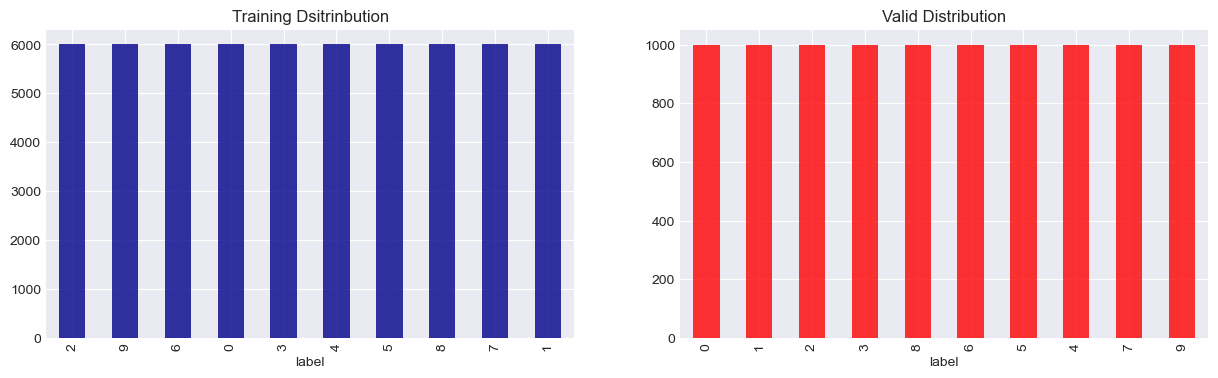

In [6]:
fn_plot_labels(train_df=train_df, test_df=valid_df) 

In [7]:
class_names = {
    0: 'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8:'Bag', 
    9: 'Ankle boot'
}

In [8]:
train_df.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


$$
\text{
    Plot the Images
}$$

$$\text{
    Train Test Split
}
$$

In [9]:
def split_feature_label(row):
    """Splits the feature and label columns.

    Args:
        row (pandas.Series): A row of the dataframe.

    Returns:
        features: np.ndarray of shape 28x28x1
        label: int
    """
    features = tf.reshape(row[1:], [28, 28, 1])
    labels = row[0]
    return features, labels

In [10]:
tmp_ds = tf.data.Dataset.from_tensor_slices((train_df))
train_ds = tmp_ds.map(split_feature_label)
train_ds= train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices((valid_df))
test_ds = tmp_ds.map(split_feature_label)
test_ds= test_ds.batch(BATCH_SIZE)


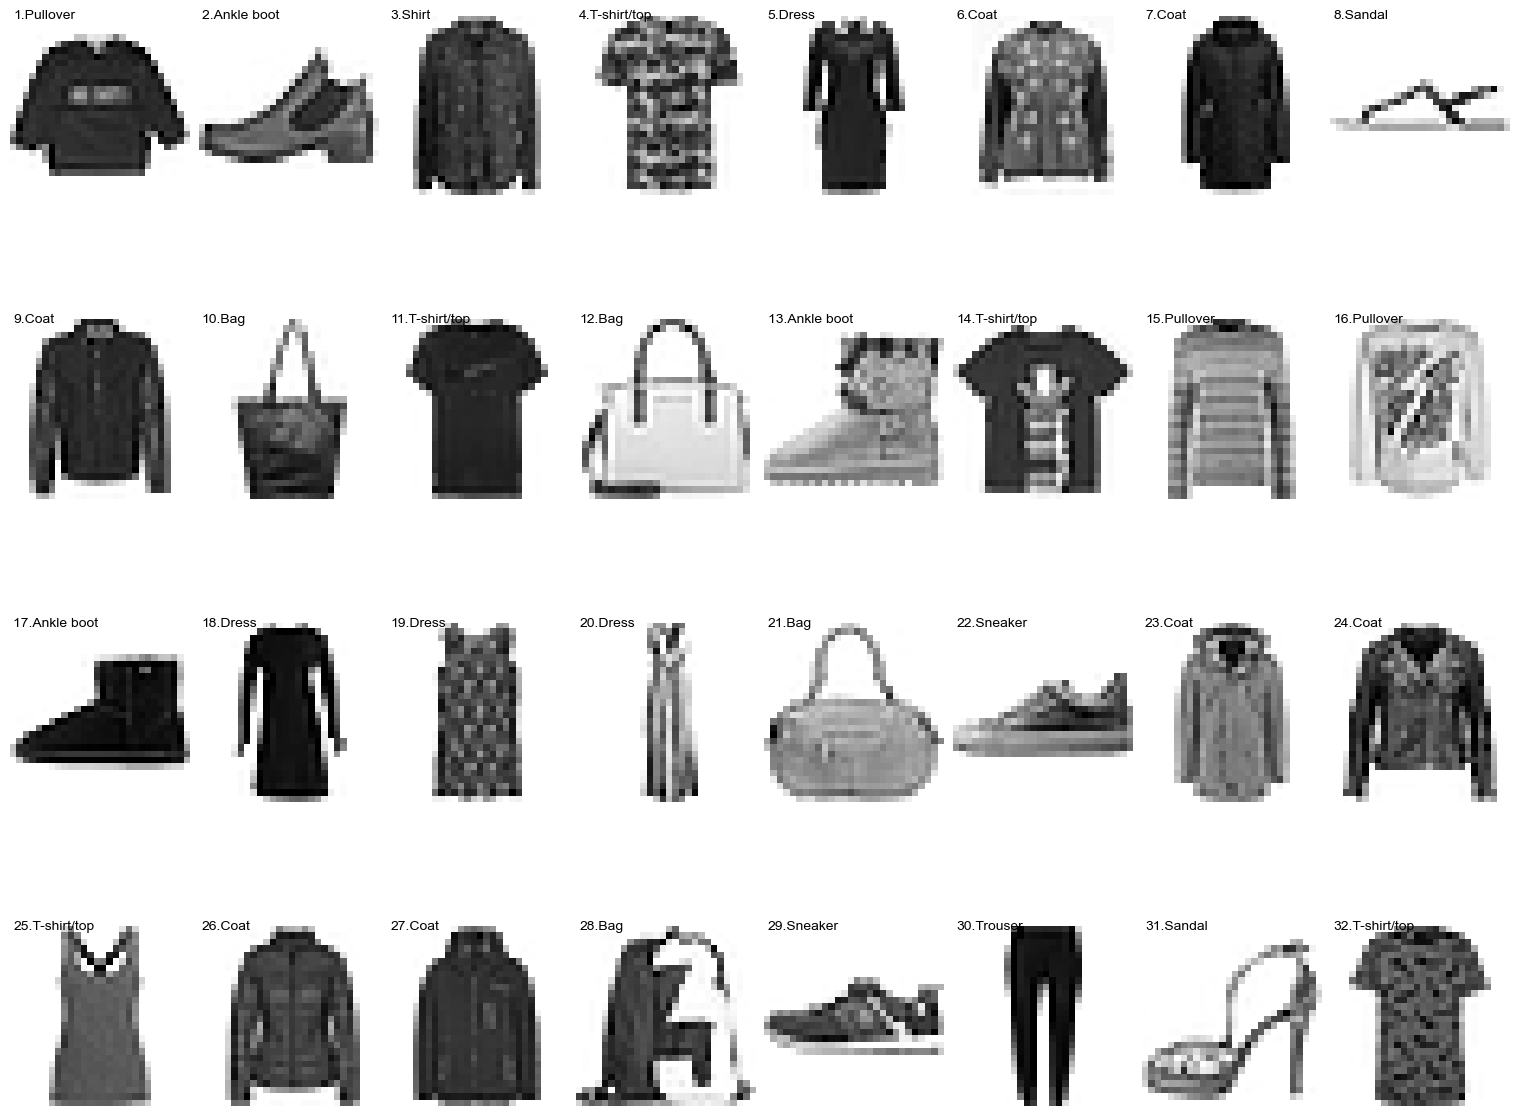

In [11]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0

#  Take 1 Batch
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'), cmap=plt.cm.binary)
        plt.text(0,0,f'{i+1}.{class_names[labels[i].numpy()]}', color='black', fontsize=10)
        plt.axis('off')
        
    plt.show()
    i += 1

plt.show()  



In [12]:
X_data = train_df.drop(columns=['label'], axis=1).to_numpy()
y_data = train_df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_valid = valid_df.drop(columns=['label'], axis=1).to_numpy()
y_valid = valid_df['label'].to_numpy()


X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((48000, 784), (12000, 784), (48000,), (12000,))

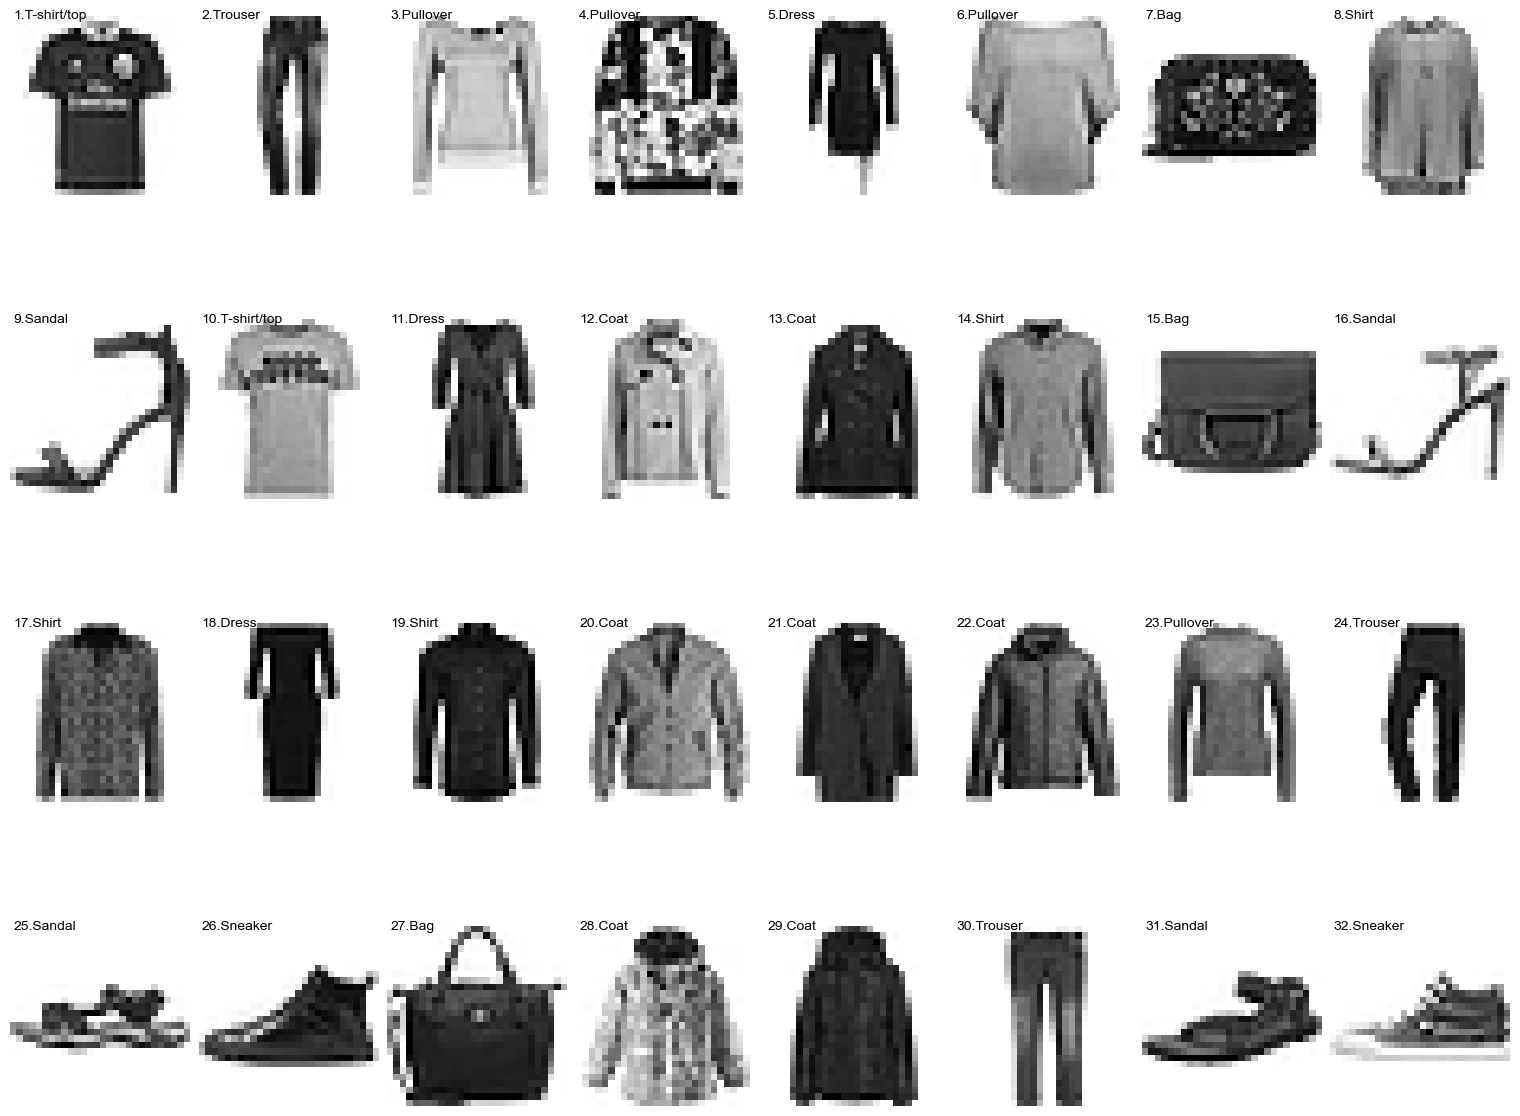

In [13]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0

#  Take 1 Batch
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'), cmap=plt.cm.binary)
        plt.text(0,0,f'{i+1}.{class_names[labels[i].numpy()]}', color='black', fontsize=10)
        plt.axis('off')
        
    plt.show()
    i += 1

plt.show()  


In [14]:
norm_layer = tf.keras.layers.Rescaling(1/255.) # initializing the normalization layer
img_batch, lbl_batch = next(iter(train_ds)) # iterating through the training data
norm_ds = train_ds.map(lambda x, y: (norm_layer(x), y)) # apply the normalization layer to the training data

img_batch, lbl_batch = next(iter(norm_ds))
display(img_batch[0].numpy().min(), img_batch[0].numpy().max())
del norm_ds


0.0

1.0

In [15]:
# optimize model for performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


### convolution layer

<Axes: >

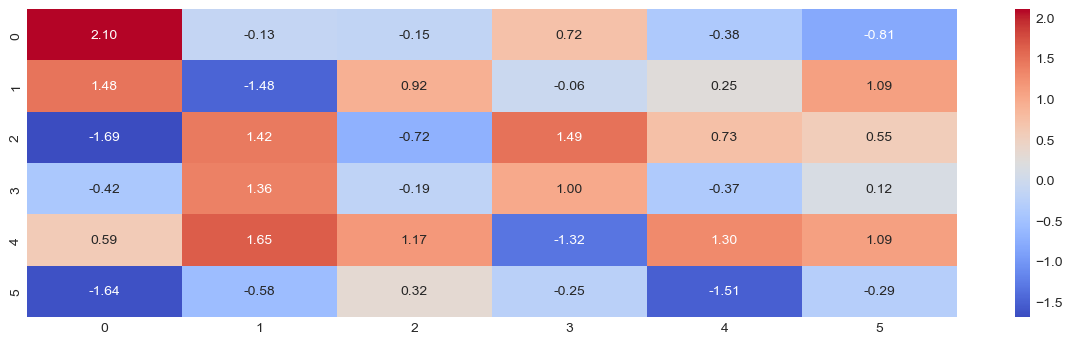

In [16]:
input_shape = (1,6,6,1) # batch , H, W, C
X = tf.random.normal(input_shape)
sns.heatmap(X.numpy()[0, :, :, 0], annot=True, fmt=".2f", cmap=CMAP)


<Axes: >

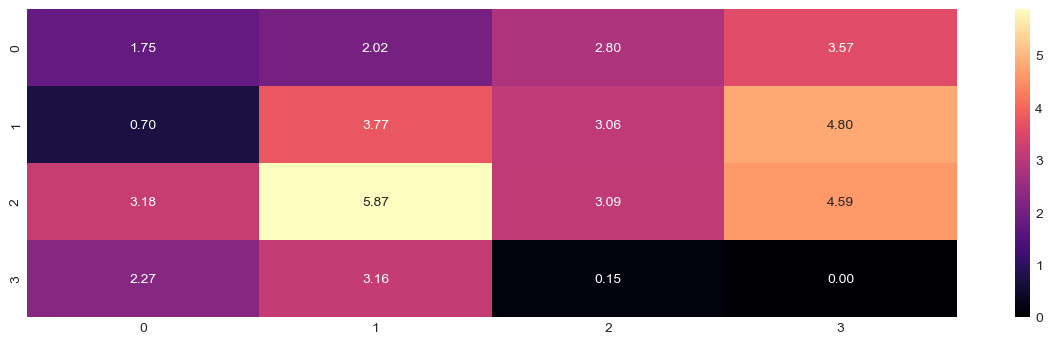

In [17]:
y = tf.keras.layers.Conv2D(1, 3, kernel_initializer=tf.constant_initializer(1.0), activation='relu', use_bias = False)(X)
sns.heatmap(y.numpy()[0, :, :, 0], annot=True, fmt=".2f", cmap="magma")

<Axes: >

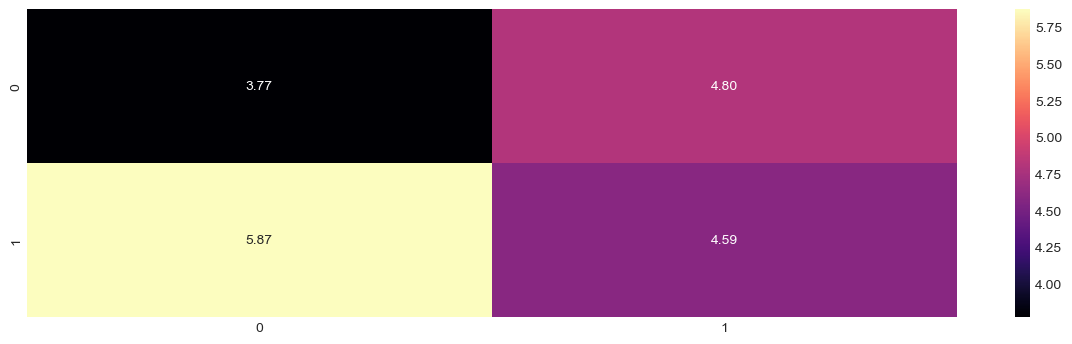

In [18]:
# pooling layer
max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)
                                     , padding='valid')
z = max_pool(y)
sns.heatmap(z.numpy()[0, :, :, 0], annot=True, fmt=".2f", cmap="magma")

In [19]:
# preparing the model

dor1, dor2, dor3, dor4, dor5, dor6 = 0.1, 0.1, 0.1, 0.3, 0.2, 0.2

# from os import name
# from sklearn import kernel_approximation


krnl_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
krnl_regularizer = tf.keras.regularizers.L2(l2=0.01)
input_shape = (28, 28, 1)








# input layer
inputs = tf.keras.Input(shape=input_shape, name='input')




# rescaling layer
x = tf.keras.layers.Rescaling(1./255.)(inputs)




# convolutional layer 1
x = tf.keras.layers.Conv2D(
    32, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    padding='same', 
    activation='relu', 
    name='conv_1')(x) # 28x28x32
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(dor1)(x)
# max pooling layer 1
x = tf.keras.layers.MaxPool2D(
    pool_size=(2,2), 
    strides=(2,2), 
    padding='same', 
    name='maxpool_1'
)(x) # 14x14x32





# convolutional layer 2
x = tf.keras.layers.Conv2D(
    64, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    padding='valid', 
    activation='relu', 
    name='conv_2')(x) # 12x12x64
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(dor2)(x)
# max pooling layer 2
x = tf.keras.layers.MaxPool2D(
    pool_size=(2,2), 
    strides=(2,2), 
    padding='valid', 
    name='maxpool_2'
)(x) # 6x6x64, if stride=None, default to pool_size





# convolutional layer 3
x = tf.keras.layers.Conv2D(
    128, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    activation='relu', 
    name='conv_3')(x
    ) # 4x4x128
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(dor3)(x)



# flattening layer
x = tf.keras.layers.Flatten()(x)






# dense layers 1
x = tf.keras.layers.Dense(
    1024,kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    activation='relu', 
    name='dense_1'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(dor4)(x)

# dense layers 2
x = tf.keras.layers.Dense(
    128,kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    activation='relu', 
    name='dense_2'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(dor5)(x)


# dense layers 3
x = tf.keras.layers.Dense(
    64,kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    activation='relu',
    name='dense_3'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(dor6)(x)


# dense layers 4
outputs = tf.keras.layers.Dense(
    10, 
    kernel_initializer=krnl_init, 
    name='output'
)(x)

In [20]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST_CNN')
model.summary()

Model: "MNIST_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           51

 Total params: 2,336,714 (8.91 MB)

 Trainable params: 2,333,834 (8.90 MB)

 Non-trainable params: 2,880 (11.25 KB)

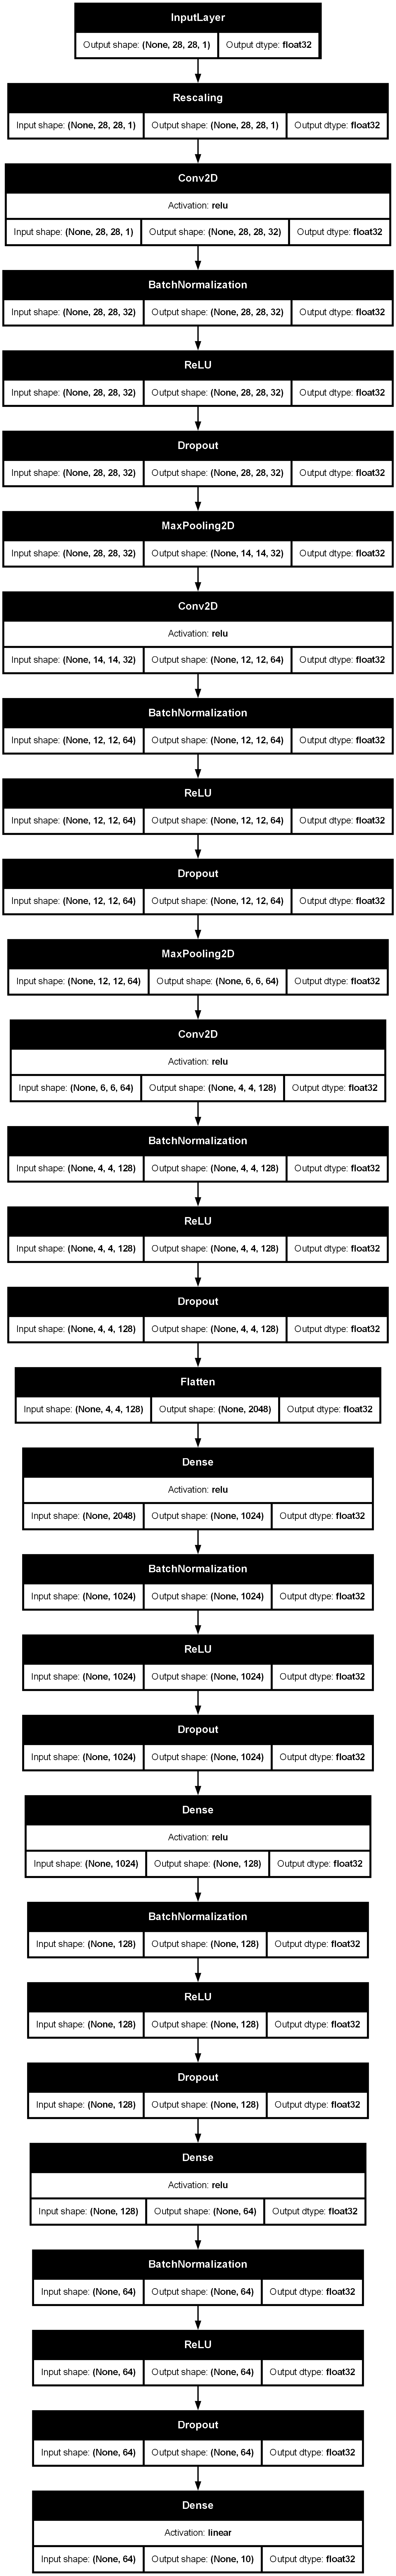

In [21]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'mnist_dataset.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)

In [22]:
# compling the model after defining the adam and loss functions
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#### Callback

In [23]:
check_file_path = os.path.join(modelDir, subDir, 'cnn.weights.h5')

# CHeckpoint 
mbc = tf.keras.callbacks.ModelCheckpoint(
    filepath = check_file_path,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

# Early Stopping
escb = tf.keras.callbacks.EarlyStopping(
    patience = PATIENCE,
    verbose = 1,
    restore_best_weights = True
)

# Reduce on Plateau
lrcb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = LR_FACTOR,
    patience = LR_PATIENCE,
    verbose = 1
)

In [24]:
history = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=test_ds,
    callbacks = [
        mbc,
        escb,
        lrcb
    ],
)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7188 - loss: 6.3449
Epoch 1: val_loss improved from inf to 1.54368, saving model to ../models\fashion_mnist\cnn.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.7188 - loss: 6.3431 - val_accuracy: 0.7493 - val_loss: 1.5437 - learning_rate: 0.0010
Epoch 2/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8178 - loss: 1.3380
Epoch 2: val_loss improved from 1.54368 to 1.16612, saving model to ../models\fashion_mnist\cnn.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - accuracy: 0.8179 - loss: 1.3380 - val_accuracy: 0.8490 - val_loss: 1.1661 - learning_rate: 0.0010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8321 - loss: 1.1800
Epoch 3: val_loss did not improve from 1.16612
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 42ms/step - accuracy: 0.8321 - loss: 1.1800 - val_accuracy: 0.7939 - val_loss: 1.2117 - learning_rate: 0.0010
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.778883,3.095571,0.7493,1.543682,0.001
1,0.820900,1.307511,0.8490,1.166118,0.001
2,0.833283,1.168876,0.7939,1.211724,0.001


,accuracy,loss,val_accuracy,val_loss,learning_rate
7,0.854100,0.826515,0.8233,0.812554,0.001
8,0.856433,0.794668,0.8266,0.850451,0.001
9,0.856850,0.770632,0.8114,0.849126,0.001


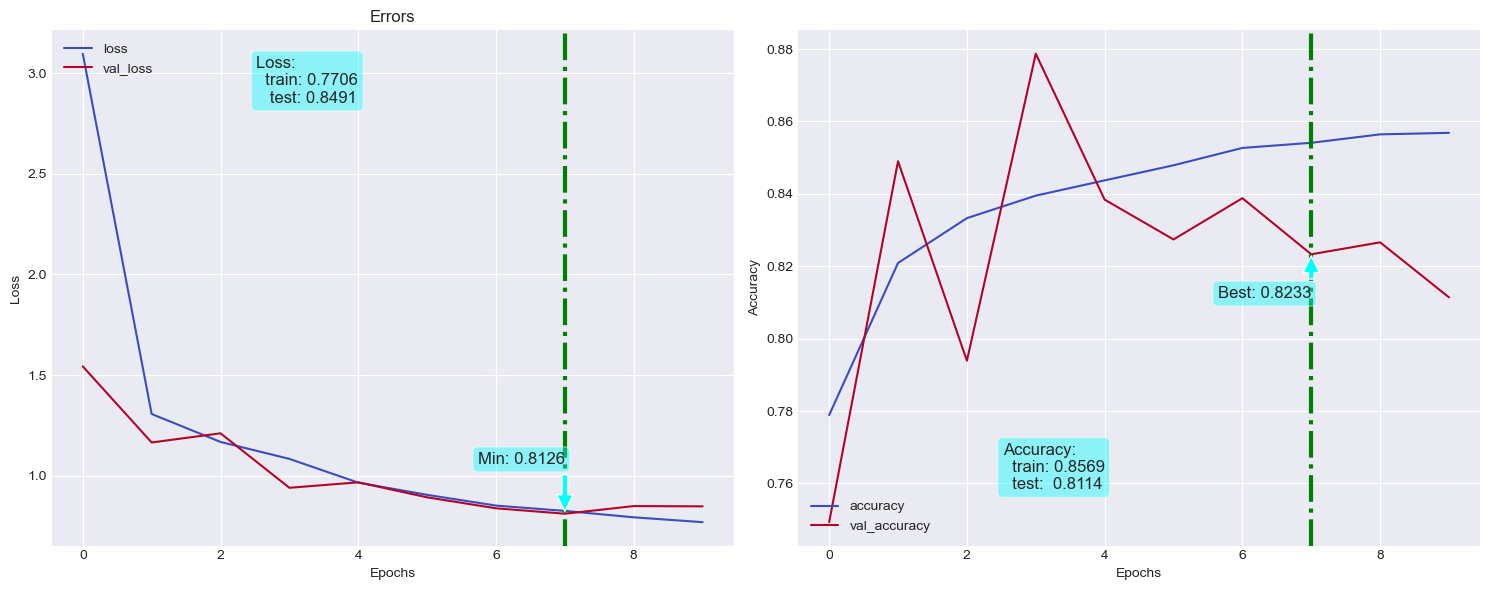

In [25]:
# results and inferences
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)




In [27]:
y_true, y_pred = [], []

for batch_idx, (X, y) in enumerate(test_ds):
    y_true.append(y)
    y_pred.append(model(X))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

y_pred = np.argmax(y_pred, axis=1)


print(f'Accuracy: {accuracy_score(y_true, y_pred):.2f}')

Accuracy: 0.82
